In [7]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
#from scipy.ndimage import gaussian_filter1d
import sys

In [8]:
date = '20220614'
dataNo = 1
scanNo = 1

In [9]:
path = r"./"+date
path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
scan_data = pd.read_csv(path_scan, delimiter='\t')

In [10]:
param_name ='T0034: Hold time for RSC (msec.)'
scan_param =scan_data[param_name]
unique_param = scan_param.unique()
sample1 = unique_param[0]
sample2 = unique_param[10]
sample3 = unique_param[20]
unit = '[ms]'
flcount = scan_data['Total count1 @ ROI1 (arb. u.)']

In [11]:
share = Path(path_img)
if share.exists():
    trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
    flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
    update_files = list(Path(path_img).glob('seq*_update001.tiff'))
else:
    print('No images')

img_flat_ave =[]
img_trans_ave = []
img_trans_list = []
for N in range(len(trans_files)):
    img_flat_ave += [np.array(Image.open(flat_files[N]))]
    img_trans_ave += [np.array(Image.open(trans_files[N]))]
img_flat_ave = np.average(img_flat_ave,axis=0)
img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
for N in range(len(trans_files)):
    img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]

img_trans_sample1 = []
img_trans_sample2 = []
img_trans_sample3 = []
for N in range(len(trans_files)):
    if scan_param[N] == sample1:
        img_trans_sample1 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample2:
        img_trans_sample2 += [np.array(Image.open(trans_files[N]))]
    elif scan_param[N] == sample3:
        img_trans_sample3 += [np.array(Image.open(trans_files[N]))]
img_trans_sample1 = np.average(img_trans_sample1,axis=0) -img_flat_ave
img_trans_sample2 = np.average(img_trans_sample2,axis=0) -img_flat_ave
img_trans_sample3 = np.average(img_trans_sample3,axis=0) -img_flat_ave

Text(0.5, 1.0, '11000.0[ms]')

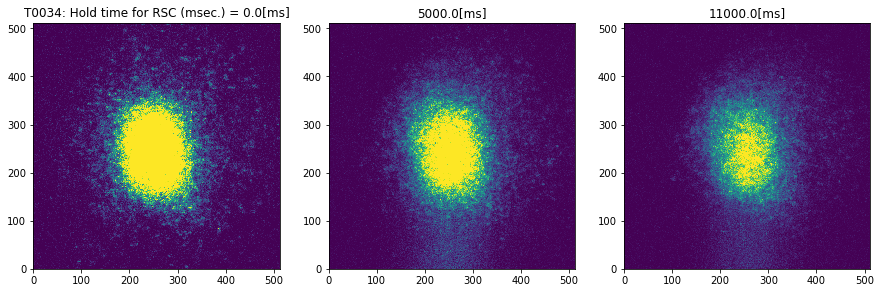

In [13]:
vmin = 0
vmax = 4000
xlim_1 = 120
xlim_2 = 320
ylim_1 = 140
ylim_2 = 340

fig =plt.figure(figsize=[15,10])
ax1 = fig.add_subplot(2,3,1)
mappable =ax1.pcolormesh(img_trans_sample1, vmin=vmin, vmax=vmax, shading='auto')
ax1.set_aspect('equal')
# ax1.set_xlim(120,320)
# ax1.set_ylim(140,340)
ax1.set_title(param_name+ " = %.01f"%(sample1)+unit)

ax2 = fig.add_subplot(2,3,2)
mappable =ax2.pcolormesh(img_trans_sample2, vmin=vmin, vmax=vmax, shading='auto')
ax2.set_aspect('equal')
# ax2.set_xlim(120,320)
# ax2.set_ylim(140,340)
ax2.set_title("%.01f"%(sample2)+unit)

ax3 = fig.add_subplot(2,3,3)
mappable =ax3.pcolormesh(img_trans_sample3, vmin=vmin, vmax=vmax, shading='auto')
ax3.set_aspect('equal')
# ax3.set_xlim(120,320)
# ax3.set_ylim(140,340)
ax3.set_title("%.01f"%(sample3)+unit)

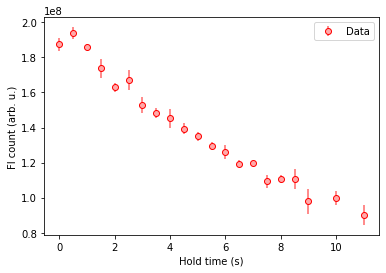

In [17]:
fl_list =[]
fl_err_list = []
for i in range(len(unique_param)):
    fl_temp = []
    for j in range(len(trans_files)):
        if scan_param[j] == unique_param[i]:
            fl_temp.append(flcount[j])
    fl_list.append(np.mean(fl_temp))
    fl_err_list.append(np.std(fl_temp))

xlabel = 'Hold time (s)'

fig =plt.figure(figsize=[6,4])
ax1 = fig.add_subplot(1,1,1)
# ax1.scatter(scan_param,wy_list, label ='y')
# ax1.scatter(scan_param,wx_list, label='x')
ax1.errorbar(unique_param*1e-3, fl_list, fl_err_list,fmt = 'o', c='#ff6666', mec='r', mfc='#ffaaaa', label = "Data")
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Fl count (arb. u.)')
ax1.legend()

fitParameter_0=14.084978576111208(0.40689778056394155)
fitParameter_1=193457624.29205385(1883007.316353989)


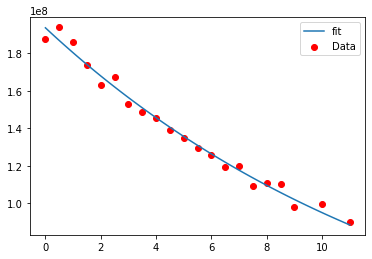

In [19]:
x_list = unique_param*1e-3
nx = fl_list
nx_err = fl_err_list

def exponential_fit(x,*fit_param):
    return fit_param[1]*np.exp(-x/fit_param[0])

def fit_result(fit_func, x_data_list, y_data_list, initial_param_list, yerr=None):
    if (yerr is None):
        param, cov = scipy.optimize.curve_fit(fit_func, x_data_list, y_data_list, p0 = initial_param_list)
    else:
        param, cov = scipy.optimize.curve_fit(fit_func, x_data_list, y_data_list, p0 = initial_param_list, sigma=yerr)
    perr = np.sqrt(np.diag(cov))
    x_fit_list = np.linspace(np.min(x_data_list),np.max(x_data_list))
    y_fit_list = []
    for num in x_fit_list:
        y_fit_list.append(fit_func(num, *param))
    return param, perr, x_fit_list, y_fit_list

para_ini=[10, np.max(nx)]
fitResultsOfSampleImage_list = fit_result(exponential_fit, x_list, nx, para_ini)

for i in range(len(para_ini)):
    print("fitParameter_"+str(i)+"="+str(fitResultsOfSampleImage_list[0][i])+"("+str(fitResultsOfSampleImage_list[1][i])+")")

plt.scatter(x_list,nx, label='Data',c="r")
plt.plot(fitResultsOfSampleImage_list[2],fitResultsOfSampleImage_list[3],label="fit")
plt.legend()

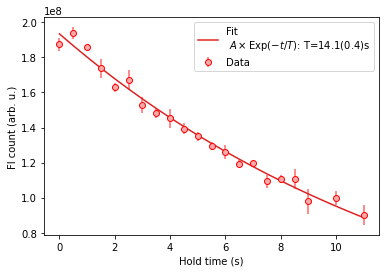

In [29]:
fit_function = r'$A \times {\rm Exp}(-t/T)$'

fig =plt.figure(figsize=[6,4])
ax1 = fig.add_subplot(1,1,1)
# ax1.scatter(scan_param,wy_list, label ='y')
# ax1.scatter(scan_param,wx_list, label='x')
ax1.errorbar(unique_param*1e-3, fl_list, fl_err_list,fmt = 'o', c='#ff6666', mec='r', mfc='#ffaaaa', label = "Data")
ax1.plot(fitResultsOfSampleImage_list[2],fitResultsOfSampleImage_list[3], c='#dd2222', label="Fit \n "+fit_function+": T=%.01f(%.01f)s"%(fitResultsOfSampleImage_list[0][0], fitResultsOfSampleImage_list[1][0]))
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Fl count (arb. u.)')
ax1.legend()